# Homework 4 - Hard coding

![alt text](https://scontent-fco2-1.xx.fbcdn.net/v/t1.6435-9/p640x640/184205866_309950770525058_7072329262818108856_n.jpg?_nc_cat=101&ccb=1-5&_nc_sid=e3f864&_nc_ohc=NV-BDW8fI68AX-nKfZT&_nc_ht=scontent-fco2-1.xx&oh=d9a93541fee5ec4b8999dcaac221d921&oe=61AE1128)

# VERY VERY IMPORTANT!

1. !!! Read the entire homework before coding anything!!!

2. My solution it's not better than yours, and yours is not better than mine. In any data analysis task, there is not a unique way to solve a problem. For this reason, it is crucial (necessary and mandatory) that you describe any single decision you take and all the steps you do.

3. Once performed any exercise, comments about the obtained results are mandatory. We are not always explicit about where to focus your comments, but we will always want some brief sentences about your discoveries and decisions.

## 1. Implementing your own Shazam 

[Shazam](https://www.shazam.com/) is a great application that can tell you the title of a song by listening to a short sample. For this task, you will implement a simplified copy of this app by dealing with hashing algorithms. In particular, you will implement your [**LSH algorithm**](https://www.learndatasci.com/tutorials/building-recommendation-engine-locality-sensitive-hashing-lsh-python/) that takes as input an audio track and finds relevant matches.

![myshazam](https://www.codeproject.com/KB/WPF/duplicates/conceptialoverview.png)

### 1.1 Getting your data!

1) Download the [dataset](https://www.kaggle.com/dhrumil140396/mp3s32k) from Kaggle. 

2) We have prepared some query songs which we would like to know the title of. You can download them from here:
- [query1](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track1.wav)
- [query2](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track2.wav)
- [query3](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track3.wav)
- [query4](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track4.wav)
- [query5](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track5.wav)
- [query6](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track6.wav)
- [query7](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track7.wav)
- [query8](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track8.wav)
- [query9](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track9.wav)
- [query10](https://sapienza2021adm.s3.eu-south-1.amazonaws.com/hw4/queries/track10.wav)

3) Now you can convert the tracks in the dataset from mp3 format to wav format. We have prepared some utility functions for this. Read the instructions in point 1.2.

### 1.2 Fingerprint hashing
We want to create a representation of our audio signal that allows us to characterize it with respect to its peaks. If you are new to audio signal processing, we recommend that you read [this introductory article](https://willdrevo.com/fingerprinting-and-audio-recognition-with-python/). It will allow you to understand this task much better. Once this process is complete, we can adopt a hashing function to get a fingerprint of each song.

To help you in the extraction phase of the audio signal we have written some utility functions for you that you can find in `AudioSignals.ipynb`. To use them you will need to install (FFMPEG)[https://www.ffmpeg.org/] and [Librosa](https://librosa.org/doc/latest/index.html) in your environment. Of course, you are free to experiment and try any other audio representation you think is best.

In [2]:
import numpy as np      
import matplotlib.pyplot as plt 
import scipy.io.wavfile 
import subprocess
import librosa
import librosa.display
import IPython.display as ipd

from pathlib import Path, PurePath   
from tqdm.notebook import tqdm

## Utility functions

In [3]:
def convert_mp3_to_wav(audio:str) -> str:  
    """Convert an input MP3 audio track into a WAV file.

    Args:
        audio (str): An input audio track.

    Returns:
        [str]: WAV filename.
    """
    if audio[-3:] == "mp3":
        wav_audio = audio[:-3] + "wav"
        if not Path(wav_audio).exists():
                subprocess.check_output(f"ffmpeg -i {audio} {wav_audio}", shell=True)
        return wav_audio
    
    return audio

def plot_spectrogram_and_picks(track:np.ndarray, sr:int, peaks:np.ndarray, onset_env:np.ndarray) -> None:
    """[summary]

    Args:
        track (np.ndarray): A track.
        sr (int): Aampling rate.
        peaks (np.ndarray): Indices of peaks in the track.
        onset_env (np.ndarray): Vector containing the onset strength envelope.
    """
    times = librosa.frames_to_time(np.arange(len(onset_env)),
                            sr=sr, hop_length=HOP_SIZE)

    plt.figure(figsize=(20, 5))
    ax = plt.subplot(2, 1, 2)
    D = librosa.stft(track)
    librosa.display.specshow(librosa.amplitude_to_db(np.abs(D), ref=np.max),
                            y_axis='log', x_axis='time')
    plt.subplot(2, 1, 1, sharex=ax)
    plt.plot(times, onset_env, alpha=0.8, label='Onset strength')
    plt.vlines(times[peaks], 0,
            onset_env.max(), color='r', alpha=0.8,
            label='Selected peaks')
    plt.legend(frameon=True, framealpha=0.8)
    plt.axis('tight')
    plt.tight_layout()
    plt.show()

def load_audio_picks(audio, duration, hop_size):
    """[summary]

    Args:
        audio (string, int, pathlib.Path or file-like object): [description]
        duration (int): [description]
        hop_size (int): 

    Returns:
        tuple: Returns the audio time series (track) and sampling rate (sr), a vector containing the onset strength envelope
        (onset_env), and the indices of peaks in track (peaks).
    """
    try:
        track, sr = librosa.load(audio, duration=duration)
        onset_env = librosa.onset.onset_strength(track, sr=sr, hop_length=hop_size)
        peaks = librosa.util.peak_pick(onset_env, 10, 10, 10, 10, 0.5, 0.5)
    except Error as e:
        print('An error occurred processing ', str(audio))
        print(e)
        

    return track, sr, onset_env, peaks
    
    

## Settings

In [4]:
N_TRACKS = 1413
HOP_SIZE = 512
DURATION = 30 # TODO: to be tuned!
THRESHOLD = 0 # TODO: to be tuned!

In [14]:
data_folder = Path("data/mp3s-32k/")
mp3_tracks = data_folder.glob("*/*/*.mp3")
tracks = data_folder.glob("*/*/*.wav")

## Preprocessing

In [6]:
for track in tqdm(mp3_tracks, total=N_TRACKS):
    convert_mp3_to_wav(str(track))

  0%|          | 0/1413 [00:00<?, ?it/s]

## Audio signals

data/mp3s-32k/metallica/Master_of_Puppets/05-Disposable_Heroes.wav
n_peaks:
74


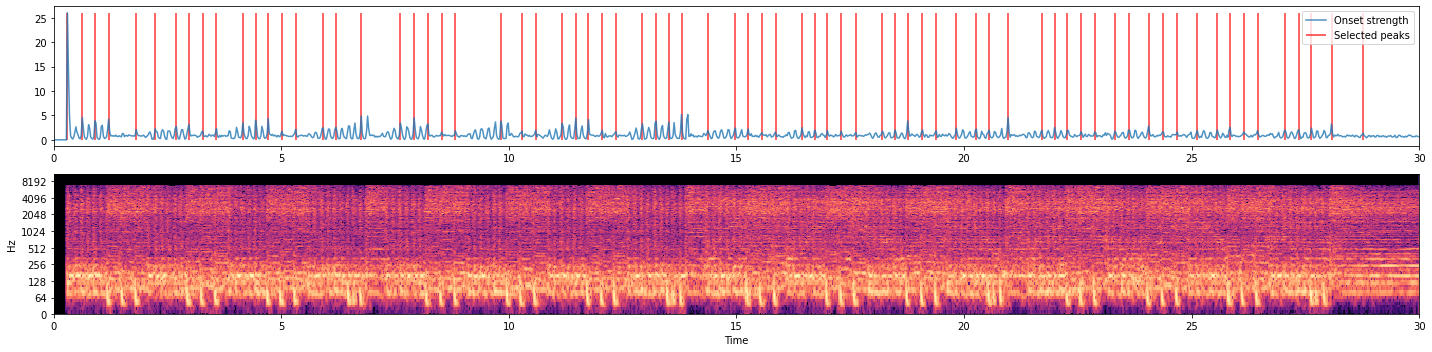

data/mp3s-32k/metallica/Master_of_Puppets/04-Welcome_Home_Sanitarium_.wav
n_peaks:
57


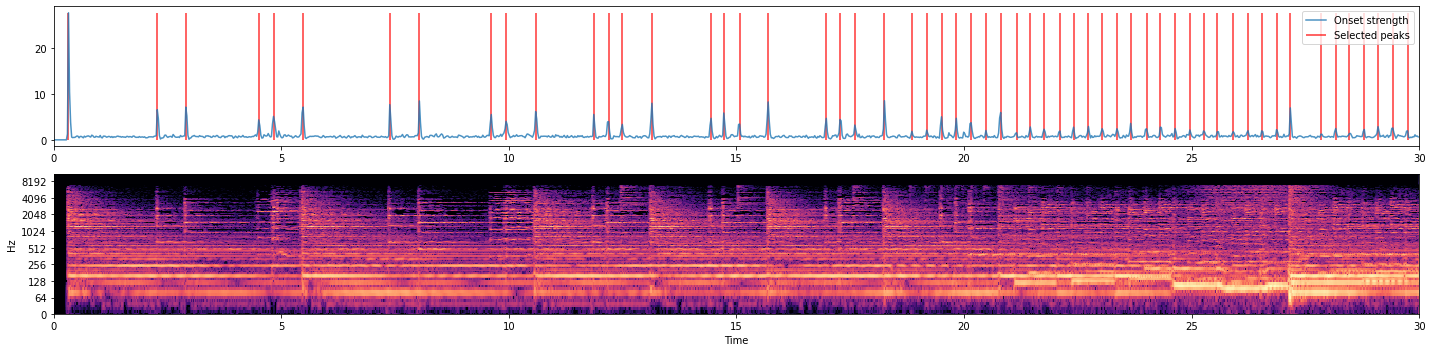

In [8]:
for idx, audio in enumerate(tracks):
    if idx >= 2:
        break
    print(audio)
    track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    print(f"n_peaks:\n{len(peaks)}")
    plot_spectrogram_and_picks(track, sr, peaks, onset_env)
        
        

In [22]:
import pandas as pd 
def create_tracks_dataframe(track_names):
    #track, sr, onset_env, peaks = load_audio_picks(audio, DURATION, HOP_SIZE)
    ret = pd.DataFrame(columns=['title', 'author', 'album', 'track', 'sr', 'onset_env', 'peaks'])
    for track_path in tqdm(track_names):
        _, _, author, album, title = str(track_path).split('/')
        title = title.split('.')[0]
        title = title[title.find('-')+1:]
        ret.loc[len(ret)] = [title, author, album] + list(load_audio_picks(track_path, DURATION, HOP_SIZE))
    return ret

In [23]:
tracks_df = create_tracks_dataframe(tracks)

  0%|          | 0/1413 [00:00<?, ?it/s]

In [24]:
tracks_df.to_csv('data/primo_db_songs.csv', index=False)

# Now it's your turn!

1) Implement your minhash function  **from scratch**. *No ready-made hash functions are allowed*. Read the class material and search the internet if you need to. As a reference, it may be useful to look at the description of hash functions in the [book](http://infolab.stanford.edu/~ullman/mmds/ch3n.pdf).

2) Read the dataset sequentially and add it to your MinHash. The aim is to make your minhash function map the same song to the same bins. You can define a threshold to control the accuracy of these matches. For example, if you want your app to suggest songs similar to the query one, you can vary the threshold accordingly. Experiment with at least 3 different values and report the results.

3) You are given 10 *query tracks*, report their title!

## Minhash

# Some Theory
Before go ahead with the implementation of MinHash let's dig into the description of what we are looking for.<br>
Suppose to have two sets $S_1$ and $S_2$ and to want to compute how much they are similar. Then the function that you're looking for is the *Jaccard similarity* that's given by the formula: 
\begin{equation}
    J(S_1, S_2) = \frac{|S_1 \cap S_2|}{|S_1 \cup S_2|}
\end{equation}
Given that compute this value is so much expensive in terms of computation, we're looking for a different representation of sets and their similarity, here comes to our aid the **MinHash** function.

Let's dig into it!<br>
## Set representation
For the aim of this discussion let's imagine a set represented by a sort of one-hot matrix, suppose that the alphabet that we are working with is made by the set {a, b, c, d, e, f} and $S_1 = \{a, b, e, f\}$  and  $S_2 = \{a, c, f\}$.

We can represent this information by the table that follows:
| Elements  | S_1  | S_2 |
|---|---|---|
| a | 1 | 1 |
| b | 1 | 0 |
| c | 0 | 1 |
| d | 0 | 0 |
| e | 1 | 0 |
| f | 1 | 1 |

Computing the jaccard similarity we have $J(S_1,S_2) = \frac{2}{6}$ given that we have two elements in common (a and f) and 6 elements in total.

What can MinHash do? Well, to ask ad this let's make a preliminar version of the minhash function that simply permutes the row of that table and takes for each set the element for which we have the first one on the set's column:
| Elements  | S_1  | S_2 |
|---|---|---|
| c | 0 | 1 |
| f | 1 | 1 |
| a | 1 | 1 |
| d | 0 | 0 |
| e | 1 | 0 |
| b | 1 | 0 |

So we will have $minHash(S_1)=f$ and $minHash(S_2)=c$.<br>
But what's the connection with jaccard? Well, the connection is that the probability to get $minHash(S_1)==minHash(S_2)$ is exactly this similarity value.<br>
I mean, the event $J_h$=\{minHash(S_1)==minHash(S_2)\}$ is described by meet a row with a double one before than a row with only one one.<br>
Intuitivelly the rows with all zeros can be ignored, so we have two tipes of rows: 
* $t_1$ that has two ones
* $o_1$ that has only one one
Give this information we can simply note that the probability to pick a $t_1$ row is given by:
\begin{equation}
    \frac{|t_1|}{|t_1| + |o_1|}
\end{equation}
But this sets are exactly the intersection and the union of this sets, so we have that two documents get the same minHash with probability equal to their jaccard similarity

Given that the cardinality of a set can be huge, we can use h(s) to create a signature of the set, in particular if we execute $n$ permutation and we compute for each permutation the minhasch, for each set we'll have n values, these n values will be the signature of that set.

Suppose to have the erlier permutation and to have these other two permutations:

| Elements  | S_1  | S_2 |
|---|---|---|
| a | 1 | 1 |
| b | 1 | 0 |
| c | 0 | 1 |
| f | 1 | 1 |
| d | 0 | 0 |
| e | 1 | 0 |


| Elements  | S_1  | S_2 |
|---|---|---|
| f | 1 | 1 |
| c | 0 | 1 |
| a | 1 | 1 |
| b | 1 | 0 |
| d | 0 | 0 |
| e | 1 | 0 |


we have that for permutation 1, 2 and 3 respectivelly, the minhash values are the follows:
\begin{align*}
    h_1(S_1) &= f\\
    h_2(S_1) &= a\\
    h_3(S_1) &= f\\
    h_1(S_2) &= c\\
    h_2(S_2) &= a\\
    h_3(S_2) &= f
\end{align*}

So the three characters signatures are:<br>
$sig(S_1) =$ faf<br>
$sig(S_2) =$ caf

## Example:
Let's see it by a simple code example:

In [39]:
import numpy as np
def foo_min_hash(s, perm):
    for p in perm:
        if p in s:
            return p
    return None

def estimate_jaccard(s1, s2, sign_len, alphabet=None):
    if alphabet is None:
        alphabet = list(s1.union(s2))
    true_cases = 0
    sig1 = ''
    sig2 = ''
    for _ in range(sign_len):
        perm = np.random.permutation(alphabet)
        c1 =foo_min_hash(s1,perm)
        c2=foo_min_hash(s2,perm)
        if c1 == c2:
            true_cases+=1
        sig1+=c1
        sig2+=c2
    return round(true_cases*1.0/sign_len, 3), (sig1, sig2)

    


In [42]:
s1 = {'a', 'b', 'e', 'f'}
s2 = {'a', 'c', 'f'}
alphabet = ['a', 'b', 'c', 'd', 'e', 'f']
cum=[]
sigs = []
n_sim = 100.0
for i in range(int(n_sim)):
    prob, sig = estimate_jaccard(s1, s2, 10, alphabet)
    sigs.append(sig)
    cum.append(prob)
print(f"jaccards: {cum}\nmean_jaccards: {round(sum(cum)/n_sim,3)}")
print(f"real_jaccard: {round(len(s1.intersection(s2))/len(s1.union(s2)), 3)}")
print(f"signatures: \n")
for s in sigs[:10]:
    print(f"\tsignature1: {s[0]} signature2: {s[1]}")



jaccards: [0.7, 0.5, 0.4, 0.7, 0.7, 0.6, 0.3, 0.5, 0.5, 0.2, 0.3, 0.4, 0.4, 0.2, 0.5, 0.4, 0.5, 0.4, 0.6, 0.3, 0.4, 0.2, 0.2, 0.5, 0.3, 0.4, 0.1, 0.1, 0.6, 0.2, 0.6, 0.3, 0.3, 0.4, 0.4, 0.3, 0.5, 0.4, 0.3, 0.3, 0.3, 0.3, 0.4, 0.3, 0.1, 0.2, 0.2, 0.5, 0.3, 0.3, 0.5, 0.5, 0.5, 0.4, 0.3, 0.6, 0.3, 0.3, 0.3, 0.2, 0.2, 0.4, 0.3, 0.2, 0.6, 0.5, 0.4, 0.5, 0.4, 0.5, 0.1, 0.5, 0.3, 0.1, 0.5, 0.6, 0.2, 0.5, 0.5, 0.6, 0.4, 0.4, 0.7, 0.3, 0.2, 0.3, 0.2, 0.3, 0.4, 0.4, 0.3, 0.4, 0.3, 0.3, 0.3, 0.5, 0.4, 0.3, 0.3, 0.1]
mean_jaccards: 0.374
real_jaccard: 0.4
signatures: 

	signature1: afaaaeaaee signature2: afaaacaaac
	signature1: afbbfbfffe signature2: afafffffcc
	signature1: feafebfbeb signature2: fcaffafaca
	signature1: aefaffaabf signature2: ccfaffaacf
	signature1: eaafafaaba signature2: caacafaaca
	signature1: feaafaeabb signature2: ffaafacaff
	signature1: aaaebfbfea signature2: accffffffc
	signature1: ffebbfffaf signature2: ffccafccaf
	signature1: bfeffbaaef signature2: ccfffcaaaf
	signature1: 

## Real MinHash
We've implemented a simple minhash, but we can't actually use it given that for big alphabet even the calcolus of the permutation can be huge, so we'll replace it with the calculation of the hash, but let's go in more details...<br>

The object of our desire is a matrix that for each hash function (that is replacing the above permutations) has a single hash value for each column (representing the set), we'll call this matrix $SIG$ and its dimension is $nxC$ where n is the number of hash functions and C is the number of the sets that we're comparing.<br>

Let's fill it!<br>
```
for each row r:
  compute $h_1(r)$, $h_2(r)$, ..., $h_n(r)$<br>
    for each column $c$:<br>
      if c has 0 in r: 
        continue
      else:
        for each i in range(n):
          SIG(i, c) = min(SIG(i, c), h_i(r))
```

So that's why this algorithm is called Min hash, for each column (set) we're taking the minimum hash value of the elements that it contains.

In [53]:
from functools import partial
def create_hash(a, b, n):
    return partial(lambda x, a,b,n: (x*a +b)%n, a=a, b=b, n=n)

def min_hash(s1, hash_f):
    return min(map(hash_f, s1))



In [58]:
rows = [0,1,2,3,4]
s1 = [0,3]
s2 = [2]
s3 = [1,3,4]
s4 = [0,2,3]

col = [s1,s2,s3,s4]


h1 = create_hash(1,1,5)
h2 = create_hash(3,1,5)
print(f"sig[1,:]: {[min_hash(s, h1) for s in col]}")
print(f"sig[2,:]: {[min_hash(s, h2) for s in col]}")

for c in range(len(col)):
    print(f"sig[:,{c}]: {[min_hash(col[c], h1),min_hash(col[c], h2)]}")

sig[1,:]: [1, 3, 0, 1]
sig[2,:]: [0, 2, 0, 0]
sig[:,0]: [1, 0]
sig[:,1]: [3, 2]
sig[:,2]: [0, 0]
sig[:,3]: [1, 0]


Okay, minhash seems to work, we have a signature, but how can we improve this?<br>
This algoritm is a shortcut for the real one where we iterate over **each** of the k rows of the one hot matrix (let's call it M), but if we choose a subset of this rows, we've much probability to reach our value of interest in one of these rows, so imagine to crop M and mantain only the first m rows, if we find there our minimum we've done, and our complexity is reduced of a factor by k/m, but we have still the possibility to have all zeros in that rows, so we should consider the remaining rows.

Not too fast!.<br>
Have all zeros